# 第六题 验证假设 展示绩效

因子名称：技术因子 动量类 CMO E010018A

因子描述：钱德动量摆动指标（Chande Momentum Osciliator），与其他动量指标摆动指标如相对强弱指标（RSI）和随机指标（KDJ）不同，钱德动量指标在计算公式的分子中采用上涨日和下跌日的数据。

计算方法：
（1）SU是今日收盘价与昨日收盘价（上涨日）差值加总。若当日下跌，则增加值为0； 
（2）SD是今日收盘价与昨日收盘价（下跌日）差值的绝对值加总。若当日上涨，则增加值为0。 
（3）CMO = (SU - SD)/ (SU + SD) * 100.

信号假设：当CMO20日均线处于低位，且5日均线上穿10日均线时，价格开始上涨，买入信号出现；当CMO20日均线处于高位，且5日均线下穿10日均线时，价格开始下跌，卖出信号出现

（1）进场信号： long:当CMO20日均线低于0，且5日均线上穿10日均线时，下多单。
short:当CMO20日均线处于高位，且5日均线下穿10日均线时，下空单。

（2）出场信号： close_long：判断当前市场是否出现新的信号可以开空单，如果空单信号出现，就平掉原来的多仓，否则继续持有多仓。
close_short：判断当前市场是否出现新的信号可以开多单，如果多单信号出现，就平掉原来的空仓，否则继续持有空仓。

### 测试该策略应用于BTCUSDT:binance的表现

In [1]:
#1、载入数据，分析品种为BTCUSDT:binance,周期为4H，开始日期为2018年6月1日
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jaqs_fxdayu.data.hf_dataview import HFDataView

warnings.filterwarnings('ignore')
ds = LocalDataService()
start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '4H',
         'start_date':20180601000000}
Time_dict = ds.bar_reader(path,props)
dv = HFDataView()
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,7))
    ax.plot(close)
    ax.set_title('4H_price_time_series')
    ax1.plot(alpha)
    ax1.set_title('factor_time_series')
    plt.show()
    
def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, MiddlePeriod=40, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,7))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(MiddlePeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    plt.show()

def Scale(df,k=1):
    return df.mul(k).div(np.abs(df).sum())

def RankPct(df):
    return df.rank(axis=1, pct=True)

Initialize dataview success.


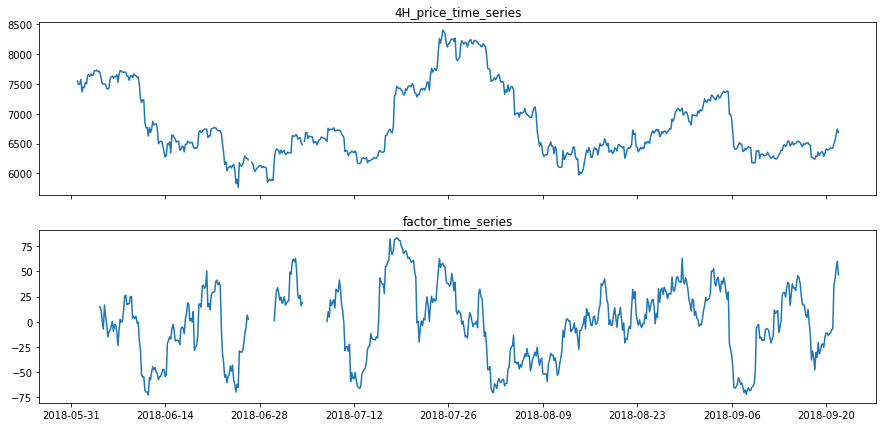

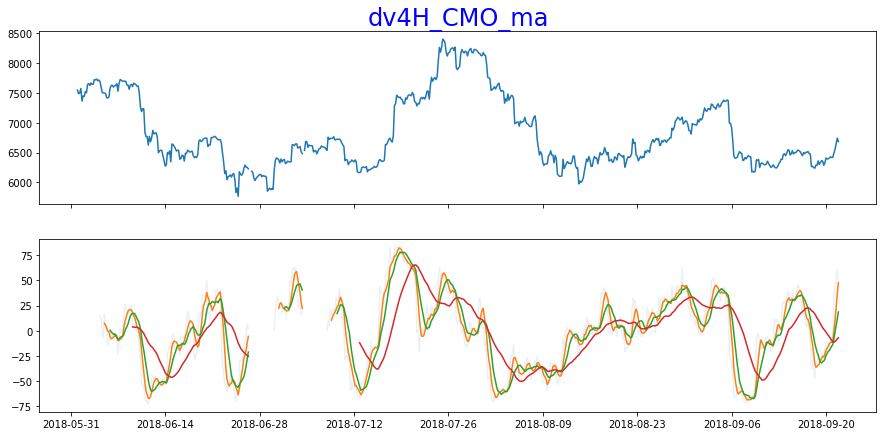

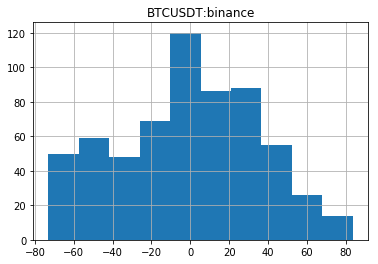

symbol,BTCUSDT:binance
count,615.000000
mean,-1.262624
std,36.038746
min,-73.026181
25%,-27.795873
50%,0.442678
75%,25.380058
max,83.591780


In [2]:
# 2、构造CMO及画图观察CMO
dv.add_formula('SU', "Ts_Sum(If(Delta(close,1)>0,close-Delay(close, 1),0),20)", add_data=True)
dv.add_formula('SD', "Ts_Sum(If(Delta(close,1)<0,Delay(close, 1)-close,0),20)", add_data=True)
dv.add_formula('CMO_J', "(SU-SD)/(SU+SD)*100", add_data=True)
close = dv.get_ts('close', date_type='datetime')
CMO_J = dv.get_ts('CMO_J',date_type='datetime').iloc[:,0]
plot_chart(close,CMO_J)
Plot_Mean(dv, CMO_J, chart_name='dv4H_CMO_ma', ShortPeriod=5, MiddlePeriod=10, LongPeriod=30, n=0)
dv.get_ts("CMO_J").hist()                                           
plt.show()
dv.get_ts("CMO_J").describe()                                                   

In [3]:
# 3、定义进出场信号
# 进场信号
long = dv.add_formula("long","If((Ts_Mean(CMO_J,5)>Ts_Mean(CMO_J,10)) && (Delay(Ts_Mean(CMO_J,5),1)<=Delay(Ts_Mean(CMO_J,10),1)) && (Ts_Mean(CMO_J,20)<0),2,0)", add_data=True)
short = dv.add_formula("short","If((Ts_Mean(CMO_J,5)<Ts_Mean(CMO_J,10)) && (Delay(Ts_Mean(CMO_J,5),1)>=Delay(Ts_Mean(CMO_J,10),1)) && (Ts_Mean(CMO_J,20)>0),-2,0)", add_data=True)
# 出场信号
close_long = dv.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

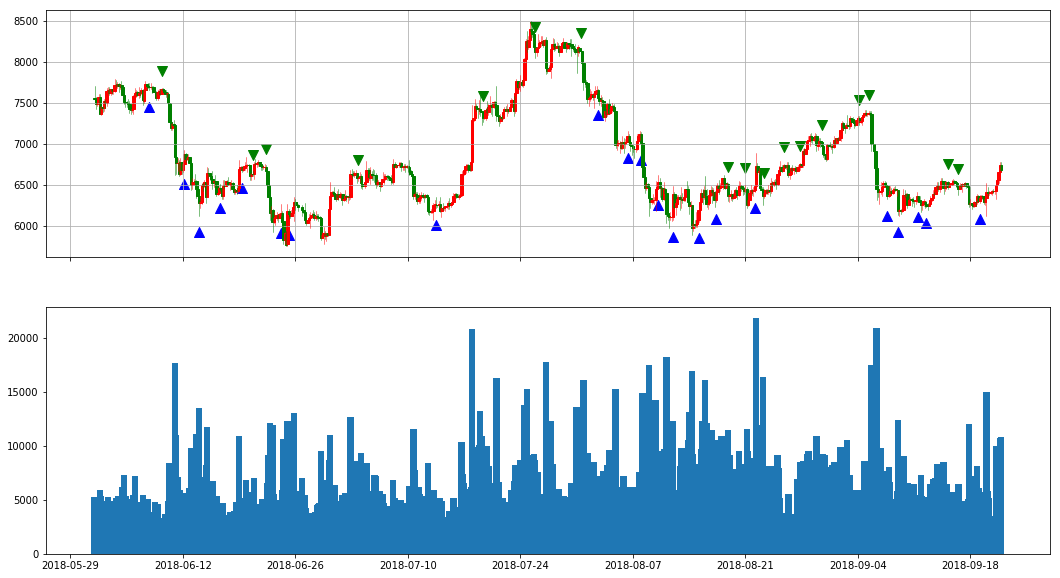

In [4]:
# 4、在k线图中画出进出场信号产生的时刻
import mpl_finance as mpf

def draw_candle_signal(candle, longX, longY,shortX,shortY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(longX, longY, color='b', s=100, marker='^')
    ax.scatter(shortX,shortY,color='g',s=100,marker='v')
    ax.xaxis_date ()
    ax1.bar(data4H.index, data4H.volume)
    plt.show()

from matplotlib.pylab import date2num

data4H = Time_dict.set_index('datetime')
data4H['candleTime'] = list(map(date2num, data4H.index))
candle = data4H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

longsignal = dv.get_ts('long', date_type='datetime')
shortsignal = dv.get_ts('short', date_type='datetime')

longX = longsignal[longsignal['BTCUSDT:binance']==2].index
longY = data4H.loc[longX].low-200
shortX = shortsignal[shortsignal['BTCUSDT:binance']==-2].index
shortY = data4H.loc[shortX].high+200

draw_candle_signal(candle,longX,longY,shortX,shortY)

In [5]:
# 5、计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='CMO_mastatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv, 100, 0.15, 0.7)
tdMaStatistic.create_event_report(sig_type="long")
tdMaStatistic.create_event_report(sig_type="short")
tdMaStatistic.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
*****-Summary-*****
Event Analysis
                       win   loss     all
t-stat               4.137 -2.690   0.801
p-value              0.002  0.031   0.433
mean                 0.054 -0.050   0.013
std                  0.044  0.049   0.069
info_ratio           1.247 -1.017   0.184
skewness             1.353 -1.214  -0.258
kurtosis             1.480  0.262   0.843
pct5                 0.010 -0.136  -0.096
pct25                0.021 -0.063  -0.016
pct50                0.045 -0.032   0.015
pct75                0.073 -0.013   0.052
pct95                0.127 -0.008   0.095
occurance           12.000  8.000  20.000
win_ratio              NaN    NaN   0.600
win_mean/loss_mean     NaN    NaN   1.088
*****-Summary-*****
Event Analysis
                       win   loss     all
t-stat               6.552 -3.972   3.186
p-value              0.000  0.05

### 测试该策略应用于EOSUSDT:binance的表现

In [6]:
#1、载入数据，分析品种为BTCUSDT:binance,周期为4H，开始日期为2018年6月1日
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jaqs_fxdayu.data.hf_dataview import HFDataView

warnings.filterwarnings('ignore')
ds = LocalDataService()
start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'EOSUSDT:binance', 'freq': '4H',
         'start_date':20180601000000}
Time_dict = ds.bar_reader(path,props)
dv = HFDataView()
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [7]:
# 2、构造CMO
dv.add_formula('SU', "Ts_Sum(If(Delta(close,1)>0,close-Delay(close, 1),0),20)", add_data=True)
dv.add_formula('SD', "Ts_Sum(If(Delta(close,1)<0,Delay(close, 1)-close,0),20)", add_data=True)
dv.add_formula('CMO_J', "(SU-SD)/(SU+SD)*100", add_data=True)

symbol,EOSUSDT:binance
trade_date,
20180601000000,NaN
20180601040000,NaN
20180601080000,NaN
20180601120000,NaN
20180601160000,NaN
20180601200000,NaN
20180602000000,NaN
20180602040000,NaN
20180602080000,NaN


In [8]:
# 3、定义进出场信号
# 进场信号
long = dv.add_formula("long","If((Ts_Mean(CMO_J,5)>Ts_Mean(CMO_J,10)) && (Delay(Ts_Mean(CMO_J,5),1)<=Delay(Ts_Mean(CMO_J,10),1)) && (Ts_Mean(CMO_J,20)<0),2,0)", add_data=True)
short = dv.add_formula("short","If((Ts_Mean(CMO_J,5)<Ts_Mean(CMO_J,10)) && (Delay(Ts_Mean(CMO_J,5),1)>=Delay(Ts_Mean(CMO_J,10),1)) && (Ts_Mean(CMO_J,20)>0),-2,0)", add_data=True)
# 出场信号
close_long = dv.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

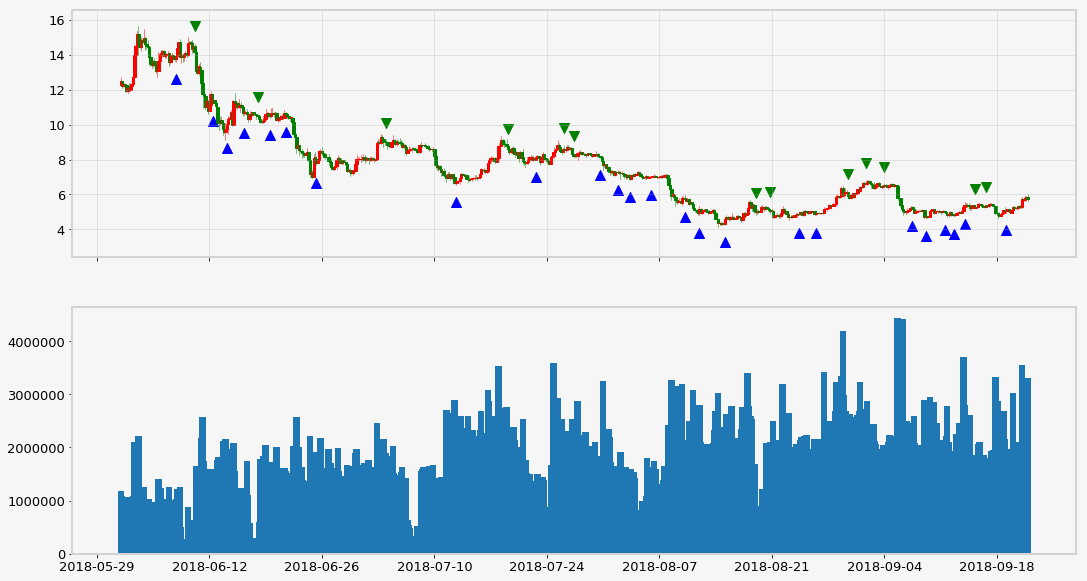

In [9]:
# 4、在k线图中画出进出场信号产生的时刻
data4H = Time_dict.set_index('datetime')
data4H['candleTime'] = list(map(date2num, data4H.index))
candle = data4H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

longsignal = dv.get_ts('long', date_type='datetime')
shortsignal = dv.get_ts('short', date_type='datetime')

longX = longsignal[longsignal['EOSUSDT:binance']==2].index
longY = data4H.loc[longX].low-1
shortX = shortsignal[shortsignal['EOSUSDT:binance']==-2].index
shortY = data4H.loc[shortX].high+1

draw_candle_signal(candle,longX,longY,shortX,shortY)

In [10]:
tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='CMO_mastatistic')
TimingSignal(tdMaStatistic, dv, 100, 0.15, 0.7)
tdMaStatistic.create_event_report(sig_type="long")
tdMaStatistic.create_event_report(sig_type="short")
tdMaStatistic.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.875  -7.100  -0.411
p-value              0.000   0.000   0.685
mean                 0.099  -0.132  -0.012
std                  0.067   0.059   0.132
info_ratio           1.470  -2.245  -0.088
skewness             0.645   0.809   0.102
kurtosis            -0.299  -0.958  -1.190
pct5                 0.012  -0.184  -0.183
pct25                0.059  -0.177  -0.163
pct50                0.083  -0.169   0.001
pct75                0.132  -0.088   0.083
pct95                0.208  -0.029   0.176
occurance           12.000  11.000  23.000
win_ratio              NaN     NaN   0.522
win_mean/loss_mean     NaN     NaN   0.749
*****-Summary-*****
Event Analysis
                       win   loss     all
t-stat               3.384 -1.484   2.156
p-value         